In [2]:
# @hidden_cell
from pymongo import MongoClient
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import json
import codecs
import numpy as np
from find_exit import FindExit
from density_generation import DMap
from matplotlib import pyplot as plt
from copy import copy
from path_finder import  AStarDynamic, AStarStatic, relocate_paths_xy
from locate_preprocess import relocate_node, expand_exits
%matplotlib inline

from bson.objectid import ObjectId

# %store -r id_list

# get map_data
# map_data = pd.read_csv('../map_data/mask_floor0.csv', header=None)
map_data = pd.read_csv('./new_map/mask_floor0.csv', header=None, sep=' ')
map_data = np.array(-(map_data - 1)).astype(int)

# get exit_list
# 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
exits = pd.read_csv('../map_data/exit_floor0.csv',header=None, )
exits = exits.T

# 坐标-->索引
exits[0] = exits[0].astype(float) 
'''看这里'''
exits[1] = 230 - exits[1].astype(float)

exit_list = np.array(exits.ix[:,[1,0]]) #令0-230的在前面

map_data = expand_exits(exit_list.astype(int), map_data)

client = MongoClient()
db = client.mapping
collection = db.people_activity

In [3]:
# gate的坐标不要转换. 
gates = pd.read_table('./new_map/admiralty_gates.txt', header=None, sep=' ')[[1,0]]

gates.columns = range(gates.shape[1])

exits_all = pd.concat([gates, pd.DataFrame(exit_list)], axis=0)[[1,0]]
exits_all.index = range(exits_all.shape[0])
exits_all.columns = range(exits_all.shape[1])

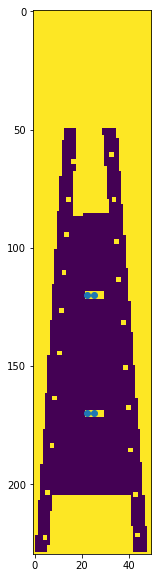

In [3]:
# test other floor
exits = pd.read_csv('../map_data/exit_floor-1.csv',header=None, )
exits = exits.T
map_data = pd.read_csv('../map_data/mask_floor-1.csv', header=None)
map_data = np.array(-(map_data - 1)).astype(int)

plt.rcParams['figure.figsize'] = (10,10)
plt.scatter(exits[0].astype(float), 230 - exits[1].astype(float))
plt.imshow(map_data)

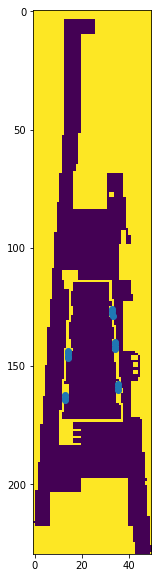

In [9]:
# test new map data
exits = pd.read_csv('../map_data/exit_floor0.csv',header=None, )
exits = exits.T
map_data = pd.read_csv('./new_map/Wechatmask_floor1.csv', header=None, sep=' ')
map_data = np.array(-(map_data - 1)).astype(int)

plt.rcParams['figure.figsize'] = (10,10)
plt.scatter(exits[0].astype(float), 230 - exits[1].astype(float))
plt.imshow(map_data)

In [4]:
generators = collection.find({'floor':0})

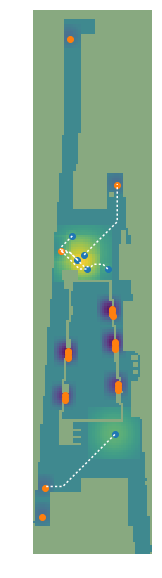

1
number is added to 2


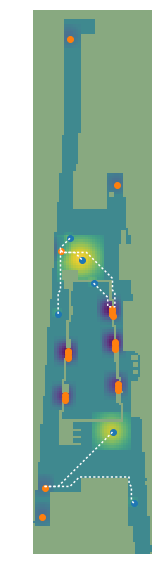

3
number is added to 4


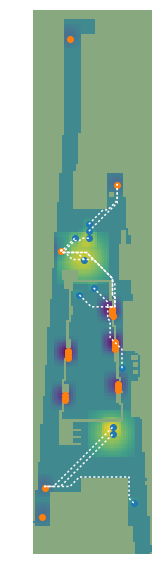

5
number is added to 6


In [ ]:
number = 0
# 注意这个只能处理floor = 0的
for record in generators:
# for ID in id_list2:
#     record = collection.find_one({'_id':ID})
    
    try:
        # get cluster_list
        # 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
        small_cluster = record['small_clusters']

        small_cluster = pd.DataFrame(small_cluster)
        small_cluster = small_cluster[small_cluster[4] > 0]
        small_cluster.index = range(len(small_cluster))

        # 坐标-->索引
        small_cluster[0] = small_cluster[0] 
        small_cluster[1] = 230 - small_cluster[1]

        cluster_list = np.array(small_cluster[[1,0]]).astype(int)
        cl = zip(cluster_list.tolist(), small_cluster[4]) # cl = [([197, 9], 1.0),...,([],1.0)]

        # 创建初始状态密度图
        M = DMap(sigma=10)
        # density_map这个函数是按照small_cluster的xy写的
        # x是0-50,y是0-230
        crowd_density = M.density_map(map_data.shape, small_cluster, crowd=True)

        # exits_list的x大,y小,所以xy坐标需要换一下位置, 
        # exits_density = M.density_map(map_data.shape, pd.DataFrame(exit_list[:,[1,0]]), sigma=5)
        exits_density = M.density_map(map_data.shape, exits_all[[1,0]], sigma=20)
        show_data = (crowd_density-exits_density) # density的图

        # find exits for each cluster
        exit_finder = FindExit(k_attr=500, k_repul=100,sigma_attr=50, sigma_repul=50)
        exits_matched = pd.DataFrame(exit_finder.find_exit_for_all(cl, np.array(gates).tolist()))

        exits_matched = pd.concat([small_cluster, exits_matched], axis=1, ignore_index=True)

        start_list1=[relocate_node(tuple(small_cluster[[1,0]].astype(int).iloc[i]), map_data, 1)  for i in range(len(small_cluster))]
        #end_list1 = [tuple(exits_matched[[6,7]].astype(int).iloc[i]+2) for i in range(len(exits_matched))]
        end_list1 = [relocate_node(tuple(exits_matched[[6,7]].astype(int).iloc[i]), map_data,1) for i in range(len(exits_matched))]

        start_end = zip(start_list1, end_list1)

        #small_cluster2 = small_cluster.copy()
        finder = AStarDynamic(map_data, small_cluster, exit_list,)

        paths_sep = finder.find_paths(start_list1, end_list1, print_or_not=False, weight_d=1,)

        paths_sep = finder.clean_paths_sep(paths_sep)
    #_____________________________________________________________
        plt.rcParams['figure.figsize'] = (10,10) 

        plt.scatter( small_cluster[0], small_cluster[1],)

        plt.scatter(exits_all[0], exits_all[1])

        # 画出路径
        for p in paths_sep:
            try:
                p = np.array(p).T
                plt.plot(p[0], p[1],c='w', linestyle=':' )
            except:
                print 'plt bug'
        show_data = crowd_density-exits_density
        masked_data = np.ma.masked_where(map_data==1, show_data)

        plt.imshow(map_data, cmap='PiYG',alpha=0.55)
        plt.imshow(masked_data, interpolation='none', alpha=0.8)

        # plt.imshow(map_data, cmap='PiYG',alpha=0.8)
        # plt.imshow(show_data, alpha=0.7)

        plt.axis('off')
        plt.show()
        number += 1
        print(number)

        # 如何写入数据库
        paths_list = [[path] for path in paths_sep]

        # new_small_clusters = np.array(pd.concat([small_cluster, pd.DataFrame(paths_list)], axis=1)).tolist()
        new_small_clusters = np.array(pd.concat([pd.DataFrame(record['small_clusters']), \
                                                     pd.DataFrame(paths_list)], axis=1)).tolist()
        # collection.update_one({u'_id':record[u'_id']}, {'$set':{'small_clusters':new_small_clusters}})

        number += 1
        print 'number is added to', number

    except:
        
        f = open('wrong_log.txt', 'aw')
        f.write(str(record['_id'])+',\n')
        f.close()
        print str(record['_id'])
    if number == 5:
            break

In [10]:
record['small_clusters']

[[21,
  122,
  0.10273446864550484,
  -2.818712103424166,
  0.4444444444444444,
  u'f1_01'],
 [35, 52, 0.069872107073667, -2.288457080536532, 0.4444444444444444, u'f1_18'],
 [18,
  126,
  0.11551376309852801,
  -1.5409421777608867,
  0.4444444444444444,
  u'f1_01'],
 [22,
  125,
  0.03890869687554814,
  -0.6362551507979691,
  0.4444444444444444,
  u'f1_01'],
 [34,
  50,
  0.08404057180528805,
  -2.3105386704248834,
  0.4444444444444444,
  u'f1_18'],
 [21,
  128,
  0.23648440431410145,
  -2.7863906449532814,
  0.6666666666666666,
  u'f1_01']]

In [11]:
paths_list = [[path] for path in paths_sep]

In [12]:
paths_list

[[[(21, 108),
   (20, 108),
   (19, 108),
   (18, 108),
   (17, 107),
   (16, 106),
   (15, 105),
   (14, 104),
   (13, 103),
   (12, 102),
   (11, 101)]],
 [[(35, 178),
   (34, 179),
   (33, 180),
   (32, 181),
   (31, 182),
   (30, 183),
   (29, 184),
   (28, 185),
   (27, 186),
   (26, 187),
   (25, 188),
   (24, 189),
   (23, 190),
   (22, 191),
   (21, 192),
   (20, 193),
   (19, 194),
   (18, 195),
   (17, 196),
   (16, 197),
   (15, 198),
   (14, 199),
   (13, 200),
   (12, 201),
   (11, 201),
   (10, 201),
   (9, 201),
   (8, 201),
   (7, 201),
   (6, 201),
   (5, 201),
   (4, 201)]],
 [[(18, 104),
   (17, 103),
   (16, 102),
   (15, 101),
   (14, 101),
   (13, 101),
   (12, 101),
   (11, 101)]],
 [[(22, 105),
   (23, 104),
   (24, 103),
   (25, 102),
   (26, 101),
   (27, 100),
   (28, 99),
   (29, 98),
   (30, 97),
   (31, 96),
   (32, 95),
   (33, 94),
   (34, 93),
   (35, 92),
   (35, 91),
   (35, 90),
   (35, 89),
   (35, 88),
   (35, 87),
   (35, 86),
   (35, 85),
   (35,

In [ ]:
pd.DataFrame(paths_list)], axis=1)).tolist()

In [13]:
new_small_clusters = np.array(pd.concat([record['small_clusters'], \
                                                 pd.DataFrame(paths_list)], axis=1)).tolist()

TypeError: cannot concatenate a non-NDFrame object

In [14]:
pd.DataFrame(paths_list)

,0
0,"[(21, 108), (20, 108), (19, 108), (18, 108), (..."
1,"[(35, 178), (34, 179), (33, 180), (32, 181), (..."
2,"[(18, 104), (17, 103), (16, 102), (15, 101), (..."
3,"[(22, 105), (23, 104), (24, 103), (25, 102), (..."
4,"[(34, 180), (33, 181), (32, 182), (31, 183), (..."
5,"[(21, 102), (22, 101), (23, 100), (24, 99), (2..."


In [11]:
strings = ['5923946f0c66a5896894622c',
'5923946f0c66a5896894622d',
'5923946f0c66a5896894622e',
'5923946f0c66a5896894622f',
'5923946f0c66a58968946230',
'5923946f0c66a58968946231',
'5923946f0c66a58968946232',
'5923946f0c66a58968946233',
'5923946f0c66a58968946234',
'5923946f0c66a58968946235',
'5923946f0c66a58968946236',
'5923946f0c66a58968946237',
'5923946f0c66a58968946238',
'5923946f0c66a58968946239',
'5923946f0c66a5896894623a',
'5923946f0c66a5896894623b',
'5923946f0c66a5896894623c',
'5923946f0c66a5896894623d',
'5923946f0c66a5896894623e',
'5923946f0c66a5896894623f',
'5923946f0c66a58968946240',
'5923946f0c66a58968946241',]

In [15]:
for s in strings:
    record = collection.find_one({'_id':ObjectId(s)})
    a = pd.DataFrame(record['small_clusters'])
    a = a[a.columns[:-1]]
    a = np.array(a).tolist()
    collection.update_one({u'_id':record[u'_id']}, {'$set':{'small_clusters':a}})

In [18]:
collection.find_one({'_id':ObjectId(s)})['small_clusters']

[[18.0, 179.0, 0.13950430845308126, -0.17358543754396633, 0.3333333333333333],
 [32.0, 102.0, 0.16509082469410705, -0.2998825563484847, 0.3333333333333333],
 [22.0, 106.0, 0.15975011866425692, -2.9469365399223197, 0.2222222222222222],
 [23.0, 167.0, 0.17012868192089847, -3.0058287355641866, 0.1111111111111111],
 [20.0, 170.0, 0.14546001771281283, -0.9796103827417847, 0.1111111111111111],
 [20.0, 167.0, 0.13671800102175388, -1.3244076025154525, 0.1111111111111111],
 [26.0, 121.0, 0.0616739640521356, -3.0900717489569898, 0.1111111111111111],
 [23.0, 121.0, 0.0309297939044273, -2.694496362064889, 0.1111111111111111],
 [25.0, 91.0, 0.0015284593627359695, -1.1643679255446324, 0.2222222222222222]]

In [24]:
from path_finder import get_gradient

In [26]:
a = get_gradient(map_data)

In [38]:
a[a>0] = 1

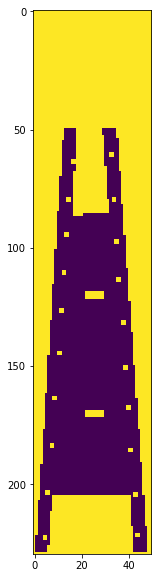

In [36]:
plt.imshow(map_data)

In [1]:
# @hidden_cell
from pymongo import MongoClient
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import json
import codecs
import numpy as np
from find_exit import FindExit
from density_generation import DMap
from matplotlib import pyplot as plt
from copy import copy
from path_finder import  AStarDynamic, AStarStatic, relocate_paths_xy
from locate_preprocess import relocate_node, expand_exits
%matplotlib inline

from bson.objectid import ObjectId

%store -r id_list

# get map_data
# map_data = pd.read_csv('../map_data/mask_floor0.csv', header=None)
map_data = pd.read_csv('./new_map/mask_floor0.csv', header=None, sep=' ')
map_data = np.array(-(map_data - 1)).astype(int)
# get exit_list
# 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
exits = pd.read_csv('../map_data/exit_floor0.csv',header=None, )
exits = exits.T

# 坐标-->索引
exits[0] = exits[0].astype(float)
exits[1] = 230 - exits[1].astype(float)

exit_list = np.array(exits.ix[:,[1,0]]).astype(int) #令0-230的在前面

map_data = expand_exits(exit_list, map_data)

client = MongoClient()
db = client.mapping
collection = db.people_activity

In [2]:
a = collection.find({'floor':0})

begin
begin
0
10
20
30
40
0:00:06.001679


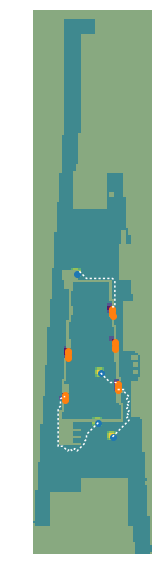

i is added to 1
begin
0
10
20
30
40
0:00:12.888028


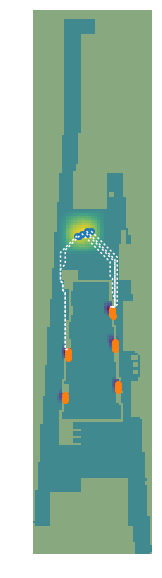

i is added to 2
begin
begin
begin
0
10
20
30
0:00:06.953570


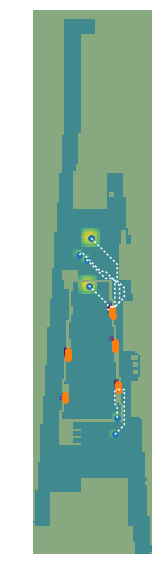

i is added to 3
begin
0
10
20
30
40
0:00:07.934552


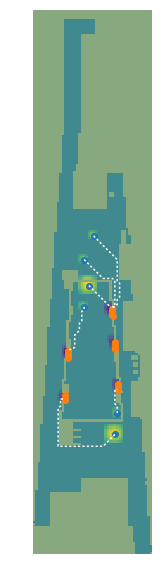

i is added to 4
begin
0
10
20
30
0:00:04.262532


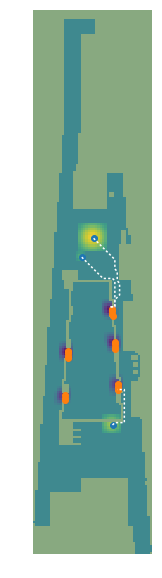

i is added to 5


In [3]:
################################################
number = 0
for record in collection.find():
# for ID in id_list2:
#     record = collection.find_one({'_id':ID})
    if record['floor'] != 0:
        pass
    else:
        print 'begin'
        try:
            #print record['floor']
            # get cluster_list
            # 注意这里的xy坐标并不是矩阵的index, 后面要进行转换.
            small_cluster = record['small_clusters']
            if len(small_cluster) !=0:


                small_cluster = pd.DataFrame(small_cluster)
                small_cluster = small_cluster[small_cluster[4] > 0]
                small_cluster.index = range(len(small_cluster))

                # 坐标-->索引
                small_cluster[0] = small_cluster[0] 
                small_cluster[1] = 230 - small_cluster[1]

                cluster_list = np.array(small_cluster[[1,0]]).astype(int)
                cl = zip(cluster_list.tolist(), small_cluster[4]) # cl = [([197, 9], 1.0),...,([],1.0)]

                # 创建初始状态密度图
                M = DMap(sigma=10)
                # density_map这个函数是按照small_cluster的xy写的
                # x是0-50,y是0-230
                crowd_density = M.density_map(map_data.shape, small_cluster, crowd=True)

                # exits_list的x大,y小,所以xy坐标需要换一下位置, 
                exits_density = M.density_map(map_data.shape, pd.DataFrame(exit_list[:,[1,0]]), sigma=5)
                show_data = (crowd_density-exits_density) # density的图

                # find exits for each cluster
                exit_finder = FindExit(k_attr=500, k_repul=100,sigma_attr=50, sigma_repul=50)
                exits_matched = pd.DataFrame(exit_finder.find_exit_for_all(cl, exit_list.tolist()))

                exits_matched = pd.concat([small_cluster, exits_matched], axis=1, ignore_index=True)

                start_list1=[relocate_node(tuple(small_cluster[[1,0]].astype(int).iloc[i]), map_data, 1)  for i in range(len(small_cluster))]
                #end_list1 = [tuple(exits_matched[[6,7]].astype(int).iloc[i]+2) for i in range(len(exits_matched))]
                end_list1 = [relocate_node(tuple(exits_matched[[6,7]].astype(int).iloc[i]), map_data,1) for i in range(len(exits_matched))]

                start_end = zip(start_list1, end_list1)

                #small_cluster2 = small_cluster.copy()
                finder = AStarDynamic(map_data, small_cluster, exit_list,)

                paths_sep = finder.find_paths(start_list1, end_list1, print_or_not=True, weight_d=2,)

                paths_sep = finder.clean_paths_sep(paths_sep)
            #_____________________________________________________________
                plt.rcParams['figure.figsize'] = (10,10) 

                plt.scatter( small_cluster[0], small_cluster[1],)

                plt.scatter(exits[0], exits[1])

                # 画出路径
                for p in paths_sep:
                    p = np.array(p).T
                    try: 
                        plt.plot(p[0], p[1],c='w', linestyle=':' )
                    except:
                        pass

                show_data = crowd_density-exits_density
                masked_data = np.ma.masked_where(map_data==1, show_data)

                plt.imshow(map_data, cmap='PiYG',alpha=0.55)
                plt.imshow(masked_data, interpolation='none', alpha=0.8)

                # plt.imshow(map_data, cmap='PiYG',alpha=0.8)
                # plt.imshow(show_data, alpha=0.7)

                plt.axis('off')
                plt.show()

                # 如何写入数据库
                paths_list = [[path] for path in paths_sep]

                new_small_clusters = np.array(pd.concat([pd.DataFrame(record['small_clusters']), \
                                                         pd.DataFrame(paths_list)], axis=1)).tolist()

                # collection.update_one({u'_id':record[u'_id']}, {'$set':{'small_clusters':new_small_clusters}})

                # number += 1
                number += 1
                print 'i is added to', number
        except:
            print 'BUG'

    if number ==5:
        break

In [24]:
for record in collection.find():
    if record['floor'] == -1:
        a = pd.DataFrame(record['small_clusters'])
        if len(a.columns) == 7:
            
            print record['_id'], record['floor']
            new = np.array(a[a.columns[:-1]]).tolist()
            
            collection.update_one({u'_id':record[u'_id']}, {'$set':{'small_clusters':new}})
        else:
            pass
    else:
        pass

59239f050c66a5f29a3568b9 -1
59239f050c66a5f29a3568bc -1
59239f050c66a5f29a3568bd -1
59239f050c66a5f29a3568be -1
59239f050c66a5f29a3568bf -1
59239f050c66a5f29a3568c0 -1
59239f050c66a5f29a3568c1 -1
59239f050c66a5f29a3568c2 -1
59239f050c66a5f29a3568c3 -1
59239f050c66a5f29a3568c4 -1
59239f050c66a5f29a3568c5 -1


In [26]:
record = collection.find_one({'floor':-2})

In [31]:
a = pd.DataFrame(record['small_clusters'])

In [32]:
a

,0,1,2,3,4,5
0,36,134,0.000000,0.000000,0.111111,f2_03
1,17,90,0.000000,0.000000,0.111111,f2_04
2,15,117,0.061482,-1.557769,0.111111,f2_04
3,15,111,0.000001,-1.909205,0.111111,f2_04
4,37,181,0.000485,-1.932984,0.222222,f2_02
5,30,109,0.000010,0.799756,0.222222,f2_03
6,40,161,0.018146,1.899085,0.111111,f2_02


In [30]:
record = collection.find_one({'_id':ObjectId('59239f050c66a5f29a3568b9')})

In [22]:
new = np.array(a[a.columns[:-1]]).tolist()

In [35]:
i = 0
for record in collection.find({'floor':-2}):
    print record['small_clusters']
    i += 1
    if i == 10:
        break

[]
[[36, 24, 0.0, 0.0, 0.1111111111111111, u'f3_01'], [24, 96, 0.0, 0.0, 0.0, u'f3_01'], [24, 99, 0.011075355068127284, -0.7784725101243505, 0.0, u'f3_01'], [27, 96, 0.0, 0.0, 0.0, u'f3_01'], [27, 99, 0.0014551626331995486, 0.46024471392877314, 0.0, u'f3_01'], [37, 68, 0.015555804077485894, -1.118664997083729, 0.1111111111111111, u'f3_01'], [9, 115, 0.0, 0.0, 0.1111111111111111, u'f3_02'], [18, 109, 0.014928805225581984, -1.902428752617488, 0.0, u'f3_01'], [26, 127, 0.00562381802463404, -0.6723275799752957, 0.1111111111111111, u'f3_02']]
[]
[]
[]
[]
[]
[]
[[12, 154, 0.030141038862591465, -1.8721165072183181, 0.1111111111111111, u'f3_02'], [13, 120, 0.018601833022070947, -1.4341910840711083, 0.4444444444444444, u'f3_02'], [29, 118, 0.000399992601440952, 1.6719805654084705, 0.3333333333333333, u'f3_02'], [34, 100, 0.0, 0.0, 0.1111111111111111, u'f3_01'], [12, 140, 0.0, 0.0, 0.1111111111111111, u'f3_02'], [37, 86, 0.0004726801916395957, -1.3864019510889103, 0.1111111111111111, u'f3_01']]


In [1]:
change_list = ['59239f050c66a5f29a3568b9',
'59239f050c66a5f29a3568bc',
'59239f050c66a5f29a3568bd',
'59239f050c66a5f29a3568be',
'59239f050c66a5f29a3568bf',
'59239f050c66a5f29a3568c0',
'59239f050c66a5f29a3568c1',
'59239f050c66a5f29a3568c2',
'59239f050c66a5f29a3568c3',
'59239f050c66a5f29a3568c4',
'59239f050c66a5f29a3568c5']

In [13]:
for s in change_list:
    record = collection.find_one({'_id':ObjectId(s)})
    small_cluster = record['small_clusters']
    small_cluster = pd.DataFrame(small_cluster)
    small_cluster.index = range(len(small_cluster))

    # 坐标-->索引
#     small_cluster[0] = small_cluster[0] 
#     small_cluster[1] = 230 -small_cluster[1]
    #new_small_clusters = np.array(small_cluster).tolist()
    print small_cluster

    0    1         2         3         4      5
0  36  134  0.000000  0.000000  0.111111  f2_03
1  17   90  0.000000  0.000000  0.111111  f2_04
2  15  117  0.061482 -1.557769  0.111111  f2_04
3  15  111  0.000001 -1.909205  0.111111  f2_04
4  37  181  0.000485 -1.932984  0.222222  f2_02
5  30  109  0.000010  0.799756  0.222222  f2_03
6  40  161  0.018146  1.899085  0.111111  f2_02
    0    1         2         3         4      5
0  26  111  0.035654 -2.795406  0.222222  f2_03
1  39  176  0.002208  1.006070  0.222222  f2_02
2  21  153  0.000000  0.000000  0.111111  f2_01
3  16   81  0.000000  0.000000  0.111111  f2_04
4  25  140  0.000000  0.000000  0.111111  f2_03
5  19  108  0.002300  0.969248  0.222222  f2_04
    0    1         2         3         4      5
0  21  153  0.000000  0.000000  0.111111  f2_01
1  19  108  0.002300  0.969248  0.222222  f2_04
2  39  176  0.002208  1.006060  0.222222  f2_02
3  16   81  0.000000  0.000000  0.111111  f2_04
4  25  140  0.000000  0.000000  0.111111

In [14]:
for s in change_list:
    record = collection.find_one({'_id':ObjectId(s)})
    small_cluster = record['small_clusters']
    small_cluster = pd.DataFrame(small_cluster)
    small_cluster.index = range(len(small_cluster))

    # 坐标-->索引
    small_cluster[0] = small_cluster[0] 
    small_cluster[1] = 230 -small_cluster[1]
    new_small_clusters = np.array(small_cluster).tolist()
    # print pd.DataFrame(new_small_clusters)
    collection.update_one({u'_id':record[u'_id']}, {'$set':{'small_clusters':new_small_clusters}})

In [2]:
from bson.objectid import ObjectId

In [1]:
from process_frame import FrameProcess
from pymongo import MongoClient

map_path = './new_map/mask_floor0.csv'
exits_path = '../map_data/exit_floor0.csv'
gates_path = './new_map/admiralty_gates.txt'

client = MongoClient()

db = client.mapping

collection = db.people_activity_path

a = collection.find({'floor': 0 })

In [3]:
record = collection.find_one({'_id':ObjectId('5923946f0c66a58968946230')})

In [4]:
model = FrameProcess()

new = model.process_one_frame_floor0(record, exits_path=exits_path, \
                                     map_path=map_path,  gates_path=gates_path,\
                                     print_or_not=False)
model.plot_results()

5923946f0c66a58968946230 , there is a bug


AttributeError: 'FrameProcess' object has no attribute 'small_cluster'

In [5]:
record['small_clusters']

[]

In [6]:
record

{u'_id': ObjectId('5923946f0c66a58968946230'),
 u'big_clusters': [],
 u'floor': 0,
 u'frame_number': 80,
 u'map_data': [[43.0, 2.0, 0.0, 0.0044201595639370645, 1.3066945929296987],
  [45.0, 2.0, 0.0, 0.004341064274996343, 1.3008771232437206],
  [46.0, 3.0, 0.0, 0.003803731170825375, 1.3234764836024424],
  [29.0, 48.0, 0.0, 0.0021912158936039593, -2.5630201661805145],
  [30.0, 48.0, 0.0, 0.0015530257671499779, -0.022953184173168814],
  [31.0, 48.0, 0.0, 0.0026368529617523152, 2.856501484655989],
  [32.0, 48.0, 0.0, 0.0012526288036298502, 2.616893484959261],
  [33.0, 48.0, 0.0, 0.0022046816865237454, -2.5595426203130494],
  [34.0, 48.0, 0.0, 0.001567545204865984, -2.9607035696885826],
  [28.0, 49.0, 0.0, 0.003414537304699346, -2.96407696714668],
  [29.0, 49.0, 0.0, 0.0008010485413627021, -0.9851813350597348],
  [30.0, 49.0, 0.0, 0.002963960956207482, -2.695341194331156],
  [31.0, 49.0, 0.0, 0.0011936164997070268, -2.215346369283524],
  [32.0, 49.0, 0.0, 0.0007759941831148542, 1.867917825